In [97]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2 as cv
import pandas as pd

In [89]:
def co_ocurrencia_matriz(img, distance, theta, normalizar = False):
    M = np.zeros((256,256), dtype = float)
    m, n = img.shape
    if theta == 0:
        horizontal_step  = distance
        vertical_step = 0
    elif theta == 45:
        horizontal_step = distance
        vertical_step = distance
    elif theta == 90:
        horizontal_step = 0
        vertical_step = distance
    elif theta == 135:
        horizontal_step = -distance
        vertical_step = distance
    for i in range(m):
        for j in range(n):
            try :
                x = i + vertical_step
                y = j + horizontal_step
                if x >= 0 and y >= 0 :
                    p1 = int(img[i,j])
                    p2 = int(img[i + vertical_step, j + horizontal_step])
                    M[p1][p2] += 1
            except IndexError:
                j = n
    if normalizar:
        return M/M.sum()
    return M

def get_descriptors_glcm(G, main_descriptors = True, normalizar = False):
    m, n = G.shape
    asm = 0
    ent = 0
    con = 0
    dis = 0
    hom = 0
    mu = 0
    for i in range(m):
        for j in range(n):
            asm += G[i,j]**2
            ent -= G[i,j]*math.log(G[i,j] + 1)
            con += G[i,j]*(i-j)**2
            dis += G[i,j]*abs(i-j)
            hom += (1/(1+ (i-j)**2))*G[i,j]
            mu += i*G[i,j]
    ene = (asm)**0.5
    cor = 0
    var = 0
    csha = 0
    cpro = 0
    for i in range(m):
        for j in range(n):
            cor += (i-mu)*(j-mu)*G[i,j]
            var += G[i,j]*(i-mu)**2
            csha += G[i,j]*(i+j-2*mu)**3
            cpro += G[i,j]*(i+j-2*mu)**4
    if main_descriptors:
        descriptors = [con, dis, hom, ene, cor, asm]
        if normalizar:
            suma = sum(descriptors)
            descriptors_norm = [x/suma for x in descriptors]
            return descriptors_norm
        else :
            return descriptors
    else:
        return [asm, ene, ent, con, dis, hom, mu, cor, var, csha, cpro]
    
def euclidean_distance(s, k):
    m = len(s)
    d = 0
    for i in range(m):
        d += (s[i] - k[i])**2
    return d

def L1_norm(s, k):
    m = len(s)
    L1 = 0
    for i in range(m):
        L1 += abs(s[i] - k[i])
    return L1

def bhattacharyya_distance(s, k):
    m = len(s)
    B = 0
    for i in range(m):
        B += (s[i]*k[i])**0.5
    return -math.log(B)

def get_distance_matrix(feature_vector, distance):
    size = len(feature_vector)
    distance_matrix = np.zeros((size, size))
    if distance == 'euclidean':
        get_distance = euclidean_distance
    elif distance == 'L1':
        get_distance = L1_norm
    elif distance == 'bhattacharyya':
        get_distance = bhattacharyya_distance
    for i in range(size):
        for j in range(size):
            distance_matrix[i][j] = round(get_distance(feature_vector[i], feature_vector[j]), 2) 
    return distance_matrix

def KNN(D, k):
    m, n = D.shape
    N = np.zeros((m,k))
    for i in range(m):
        knn = np.argsort(D[i,:])[:k+1]
        N[i] = knn[1:]
    return N

# Clasificación de imagenes en escala de grises

Creamos la matriz de co-ocurrencia para cada imagen

In [32]:
# Definimos la ruta
path = '/home/vega/Escritorio/vision_artificial/Ingeniería de Calidad-20230520T201236Z-001/Ingeniería de Calidad/Images/Texture/Colored_Brodatz/Colored Brodatz/'
# Obtenemos la matriz de co-ocurrencia de cada imagen
GLCM_1_0 = []
GLCM_1_45 = []
GLCM_1_90 = []
GLCM_1_135 = []
for k in range(1,113):
    image_name = path + 'D' + str(k) + '_COLORED.tif'
    img = cv.imread(image_name, cv.IMREAD_GRAYSCALE)
    GLCM_1_0.append(co_ocurrencia_matriz(img, 1, 0, True))
    GLCM_1_45.append(co_ocurrencia_matriz(img, 1, 45, True))
    GLCM_1_90.append(co_ocurrencia_matriz(img, 1, 90, True))
    GLCM_1_135.append(co_ocurrencia_matriz(img, 1, 135, True))

Construimos un vector de características para cada imagen

In [47]:
# Obtenemos las características para cada imagen a partir de su matriz de co-ocurrencia
num_matrices = len(GLCM_1_0)
features_0 = []
features_45 = []
features_90 = []
features_135 = []
for i in range(num_matrices):
    features_0.append(get_descriptors_glcm(GLCM_1_0[i]))
    features_45.append(get_descriptors_glcm(GLCM_1_45[i]))
    features_90.append(get_descriptors_glcm(GLCM_1_90[i]))
    features_135.append(get_descriptors_glcm(GLCM_1_135[i]))

In [48]:
# Concatenamos los vectores de características
long = len(features_from_glcm_0)
features = []
for i in range(long):
    features.append(features_0[i] + features_45[i] + features_90[i] + features_135[i])

Creamos la matriz de distancias con respecto a los vectores de características

In [70]:
distance_matrix_euclidean = get_distance_matrix(features, 'euclidean')
distance_matrix_l1 = get_distance_matrix(features, 'L1')

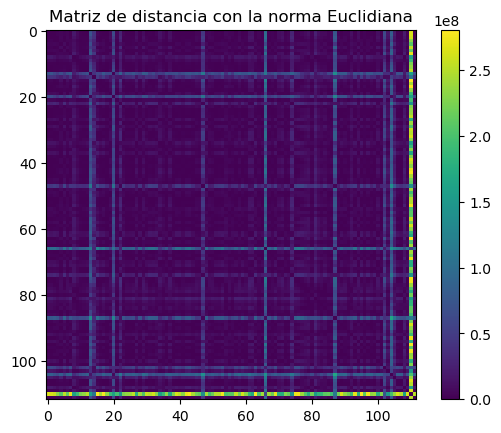

In [71]:
fig, ax = plt.subplots()
im = ax.imshow(distance_matrix_euclidean)
plt.title('Matriz de distancia con la norma Euclidiana')
cbar = ax.figure.colorbar(im, ax = ax)

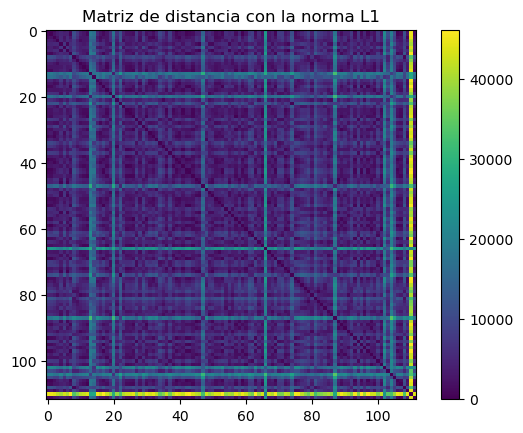

In [67]:
fig, ax = plt.subplots()
im = ax.imshow(distance_matrix_l1)
plt.title('Matriz de distancia con la norma L1')
cbar = ax.figure.colorbar(im, ax = ax)


Obtenemos los n vecinos mas cercanos para cada imagen

In [107]:
knn_4_euclidean = pd.DataFrame(KNN(distance_matrix_euclidean, 4).astype(int))
knn_4_euclidean.to_csv('knn_4_euclidean.csv')
knn_4_l1 = pd.DataFrame(KNN(distance_matrix_l1, 4).astype(int))
knn_4_l1.to_csv('knn_4_l1.csv')

# Clasificación de imágenes a color

In [119]:
path = '/home/vega/Escritorio/vision_artificial/Ingeniería de Calidad-20230520T201236Z-001/Ingeniería de Calidad/Images/Texture/Colored_Brodatz/Colored Brodatz/'

In [129]:
def get_glcm(path, chanel):
    GLCM_1_0 = []
    GLCM_1_45 = []
    GLCM_1_90 = []
    GLCM_1_135 = []
    for k in range(1,113):
        image_name = path + 'D' + str(k) + '_COLORED.tif'
        img = cv.imread(image_name, cv.IMREAD_COLOR)[chanel]
        GLCM_1_0.append(co_ocurrencia_matriz(img, 1, 0, True))
        GLCM_1_45.append(co_ocurrencia_matriz(img, 1, 45, True))
        GLCM_1_90.append(co_ocurrencia_matriz(img, 1, 90, True))
        GLCM_1_135.append(co_ocurrencia_matriz(img, 1, 135, True))
    return [GLCM_1_0, GLCM_1_45, GLCM_1_90, GLCM_1_135]

def get_features(lista_glcm):
    num_matrices = len(lista_glcm[0])
    features_0 = []
    features_45 = []
    features_90 = []
    features_135 = []
    for i in range(num_matrices):
        features_0.append(get_descriptors_glcm(lista_glcm[0][i]))
        features_45.append(get_descriptors_glcm(lista_glcm[1][i]))
        features_90.append(get_descriptors_glcm(lista_glcm[2][i]))
        features_135.append(get_descriptors_glcm(lista_glcm[3][i]))
    return [features_0, features_45, features_90, features_135]

def concat_features(lista_features):
    long = len(lista_features[0])
    features = []
    for i in range(long):
        features.append(lista_features[0][i] + lista_features[1][i] + lista_features[2][i] + lista_features[3][i])
    return features

## Blue

In [134]:
glcm_blue = get_glcm(path, 0)
features_blue = get_features(glcm_blue)
global_features_blue = concat_features(features_blue)

In [135]:
distance_matrix_euclidean = get_distance_matrix(global_features_blue, 'euclidean')
distance_matrix_l1 = get_distance_matrix(global_features_blue, 'L1')

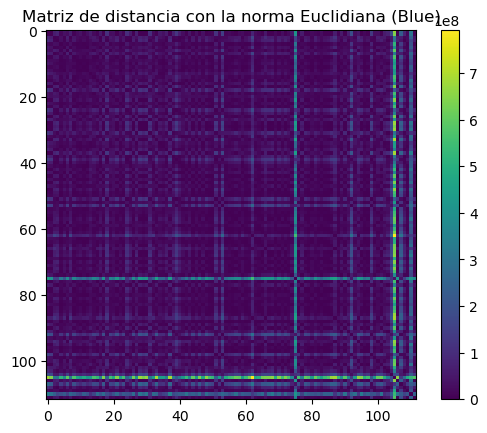

In [136]:
fig, ax = plt.subplots()
im = ax.imshow(distance_matrix_euclidean)
plt.title('Matriz de distancia con la norma Euclidiana (Blue)')
cbar = ax.figure.colorbar(im, ax = ax)

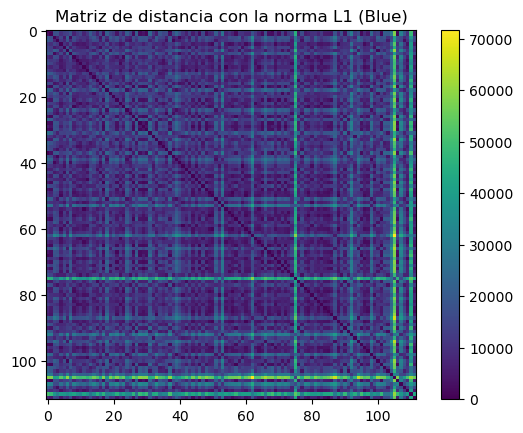

In [138]:
fig, ax = plt.subplots()
im = ax.imshow(distance_matrix_l1)
plt.title('Matriz de distancia con la norma L1 (Blue)')
cbar = ax.figure.colorbar(im, ax = ax)


In [139]:
knn_4_euclidean = pd.DataFrame(KNN(distance_matrix_euclidean, 4).astype(int))
knn_4_euclidean.to_csv('knn_4_euclidean_blue.csv')
knn_4_l1 = pd.DataFrame(KNN(distance_matrix_l1, 4).astype(int))
knn_4_l1.to_csv('knn_4_l1_blue.csv')

## Green

In [140]:
glcm_green = get_glcm(path, 1)
features_green = get_features(glcm_green)
global_features_green = concat_features(features_green)

In [141]:
distance_matrix_euclidean = get_distance_matrix(global_features_green, 'euclidean')
distance_matrix_l1 = get_distance_matrix(global_features_green, 'L1')

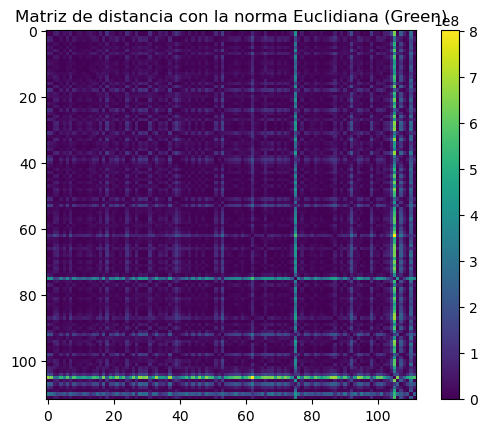

In [142]:
fig, ax = plt.subplots()
im = ax.imshow(distance_matrix_euclidean)
plt.title('Matriz de distancia con la norma Euclidiana (Green)')
cbar = ax.figure.colorbar(im, ax = ax)

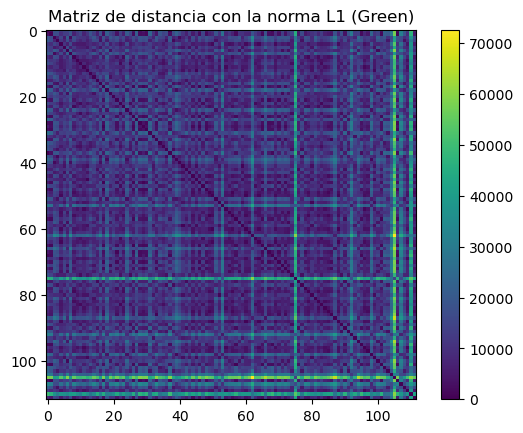

In [143]:
fig, ax = plt.subplots()
im = ax.imshow(distance_matrix_l1)
plt.title('Matriz de distancia con la norma L1 (Green)')
cbar = ax.figure.colorbar(im, ax = ax)

In [144]:
knn_4_euclidean = pd.DataFrame(KNN(distance_matrix_euclidean, 4).astype(int))
knn_4_euclidean.to_csv('knn_4_euclidean_green.csv')
knn_4_l1 = pd.DataFrame(KNN(distance_matrix_l1, 4).astype(int))
knn_4_l1.to_csv('knn_4_l1_green.csv')

## Red

In [145]:
glcm_red = get_glcm(path, 2)
features_red = get_features(glcm_red)
global_features_red = concat_features(features_red)

In [146]:
distance_matrix_euclidean = get_distance_matrix(global_features_red, 'euclidean')
distance_matrix_l1 = get_distance_matrix(global_features_red, 'L1')

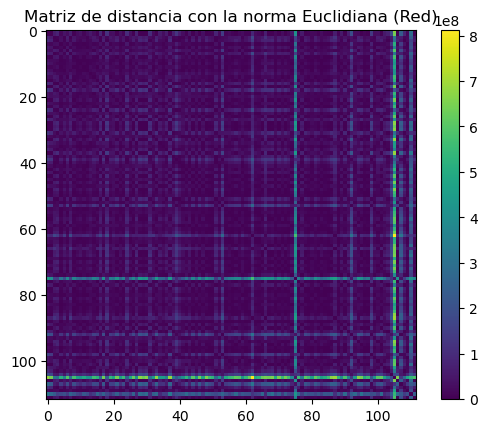

In [147]:
fig, ax = plt.subplots()
im = ax.imshow(distance_matrix_euclidean)
plt.title('Matriz de distancia con la norma Euclidiana (Red)')
cbar = ax.figure.colorbar(im, ax = ax)

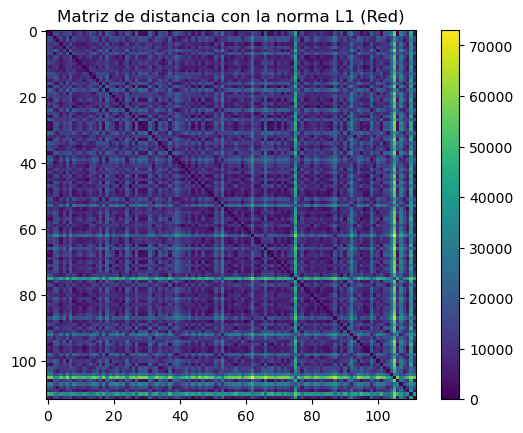

In [148]:
fig, ax = plt.subplots()
im = ax.imshow(distance_matrix_l1)
plt.title('Matriz de distancia con la norma L1 (Red)')
cbar = ax.figure.colorbar(im, ax = ax)

In [149]:
knn_4_euclidean = pd.DataFrame(KNN(distance_matrix_euclidean, 4).astype(int))
knn_4_euclidean.to_csv('knn_4_euclidean_red.csv')
knn_4_l1 = pd.DataFrame(KNN(distance_matrix_l1, 4).astype(int))
knn_4_l1.to_csv('knn_4_l1_red.csv')

## RGB

In [153]:
features_rgb = []
for i in range(len(global_features_blue)):
    features_rgb.append(global_features_blue[i] + global_features_green[i] + global_features_red[i])

In [157]:
distance_matrix_euclidean = get_distance_matrix(features_rgb, 'euclidean')
distance_matrix_l1 = get_distance_matrix(features_rgb, 'L1')

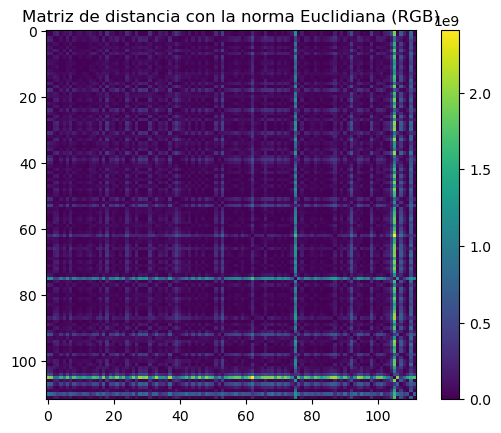

In [158]:
fig, ax = plt.subplots()
im = ax.imshow(distance_matrix_euclidean)
plt.title('Matriz de distancia con la norma Euclidiana (RGB)')
cbar = ax.figure.colorbar(im, ax = ax)

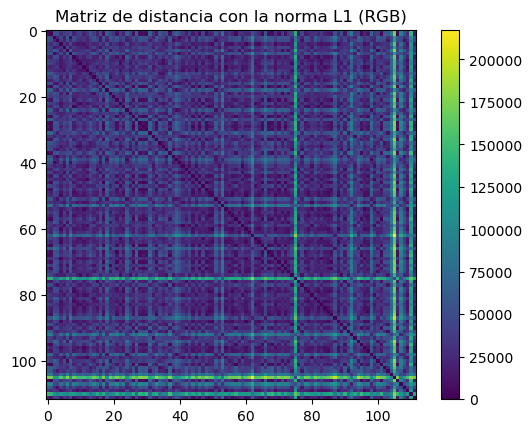

In [159]:
fig, ax = plt.subplots()
im = ax.imshow(distance_matrix_l1)
plt.title('Matriz de distancia con la norma L1 (RGB)')
cbar = ax.figure.colorbar(im, ax = ax)

In [160]:
knn_4_euclidean = pd.DataFrame(KNN(distance_matrix_euclidean, 4).astype(int))
knn_4_euclidean.to_csv('knn_4_euclidean_rgb.csv')
knn_4_l1 = pd.DataFrame(KNN(distance_matrix_l1, 4).astype(int))
knn_4_l1.to_csv('knn_4_l1_rgb.csv')